In [16]:
import matplotlib.pyplot as plt
import json
from run import run as run_lca
from run_baseline import run as run_baseline
from tools import *
from init_logger import init_logger
import os
import ga_driver
import numpy as np
import exp_scores as es
import gamma_scores as gs
import bayesian_scores as bs
import extexp_scores as ees
import logistic_scores
import isotonic_scores
from kernel_density_scores import kernel_density_scores

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import weighter

config = get_config("configs/config_spermwhale.yaml")
lca_config = config['lca']
db_path = os.path.join(lca_config['db_path'], config['exp_name'])

verifier_file =  os.path.join(db_path, "verifiers_probs.json")
wgtrs_calib_dict = load_json(verifier_file)
lca_config['logging']['log_file'] = None
lca_params = generate_ga_params(lca_config)
probs = wgtrs_calib_dict['miewid']
# wgtrs = ga_driver.generate_weighters(
#             lca_params, wgtrs_calib_dict
#         )
exp_scorer = es.exp_scores.create_from_samples(
            probs['gt_positive_probs'], probs['gt_negative_probs']
        )
gamma_scorer = gs.gamma_scores.create_from_samples(
            probs['gt_positive_probs'], probs['gt_negative_probs']
        )

pos_scores = probs["gt_positive_probs"]
neg_scores = probs["gt_negative_probs"]

# wgtr = wgtrs[0]#weighter.weighter(gamma_scorer, config["lca"]["edge_weights"]['prob_human_correct'])

In [19]:
verifier_file

'tmp/spermwhale_encounters_kde_full/verifiers_probs.json'

In [21]:
from tools import load_json, load_pickle

exp_name = config['exp_name']

initial_edges = load_json(f"/ekaterina/work/src/lca/lca/tmp/initial_edges_{exp_name}.json")

print(len(initial_edges))


pos = [s for (a0, a1, s, w, c) in initial_edges if c and w > 0]
neg = [s for (a0, a1, s, w, c) in initial_edges if ((not c) and w < 0)] 
intersect = [s for (a0, a1, s, w, c) in initial_edges if ((not c) and w >= 0) or (c and w <= 0)] 

pos_weights = [w / 10 for (a0, a1, s, w, c) in initial_edges if c and w > 0]
neg_weights = [w / 10 for (a0, a1, s, w, c) in initial_edges if (not c) and w < 0]
intersect_weights = [w / 10 for (a0, a1, s, w, c) in initial_edges if ((not c) and w >= 0) or (c and w <= 0)]

14868


In [22]:
np.array(initial_edges).shape

(14868, 5)

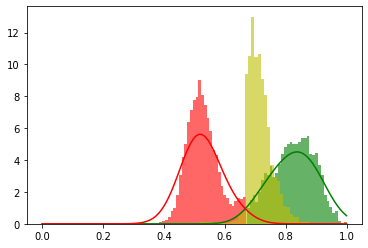

In [26]:
plt.hist(pos, bins=35, density=True, alpha=0.6, color='g')
plt.hist(neg, bins=35, density=True, alpha=0.6, color='r')
plt.hist(intersect, bins=35, density=True, alpha=0.6, color='y')

scorer = kernel_density_scores.create_from_samples(
            pos, neg
        )
# scorer = kernel_density_scores.create_from_samples(
#             pos, neg
#         )
xs = np.linspace(0, 1, 100)
wgtr = weighter.weighter(scorer, config["lca"]["edge_weights"]['prob_human_correct'])
pos_ys = [wgtr.scorer.get_pos_neg(x)[0] for x in xs]
neg_ys = [wgtr.scorer.get_pos_neg(x)[1] for x in xs]
plt.plot(xs, pos_ys, color='g')
plt.plot(xs, neg_ys, color='r')


plt.show()

In [38]:

X = np.concatenate((pos, neg, intersect))
y = np.concatenate((np.zeros(len(pos)), np.ones(len(neg)), 2*np.ones(len(intersect))))

In [40]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
# from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]



datasets = [
    (X.reshape(-1, 1),y)
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.4, random_state=42
    )

    x_min, x_max = X.min() - 0.5, X.max() + 0.5
    y_min, y_max = X.min() - 0.5, X.max() + 0.5
    
    
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        # score = clf.score(X_test, y_test)
        # Calculate class weights
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_test), y=y_test)
        class_weight_dict = dict(zip(np.unique(y_test), class_weights))

        # Generate sample weights based on class weights
        sample_weights = np.array([class_weight_dict[label] for label in y_test])

        # Now you can pass these sample weights into the scoring function or any weighted metric calculation
        weighted_score = clf.score(X_test, y_test, sample_weight=sample_weights)
        print(name, weighted_score)
        target_names = ['Pos', 'Neg', 'Hard']
        y_pred = clf.predict(X_test)
        print(classification_report(y_test, y_pred, target_names=target_names))
        # Plot the training points
        i += 1


Nearest Neighbors 0.8534735229464574
              precision    recall  f1-score   support

         Pos       0.83      0.80      0.81       996
         Neg       0.99      1.00      1.00      4142
        Hard       0.75      0.76      0.76       810

    accuracy                           0.93      5948
   macro avg       0.86      0.85      0.86      5948
weighted avg       0.93      0.93      0.93      5948

Linear SVM 0.8808511965729279
              precision    recall  f1-score   support

         Pos       0.89      0.81      0.85       996
         Neg       1.00      0.98      0.99      4142
        Hard       0.71      0.85      0.78       810

    accuracy                           0.93      5948
   macro avg       0.87      0.88      0.87      5948
weighted avg       0.94      0.93      0.94      5948

RBF SVM 0.8839440743103681
              precision    recall  f1-score   support

         Pos       0.89      0.81      0.85       996
         Neg       0.99      0.99  

<Figure size 1944x648 with 0 Axes>